In [33]:
from fuzzy_matching import fuzzy_matching
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap

df_occupation_manual = pd.read_csv('true_science/ENS - True Science - cleaning_top_occupations.csv')
df_occupation_manual = df_occupation_manual[df_occupation_manual['erase']!=1].reset_index(drop=True)


In [71]:
import torch
from transformers import AutoModel, AutoTokenizer
from scipy.spatial.distance import cosine

# Get our models - The package will take care of downloading the models automatically
# For best performance: Muennighoff/SGPT-5.8B-weightedmean-nli-bitfit
tokenizer = AutoTokenizer.from_pretrained("Muennighoff/SGPT-125M-weightedmean-nli-bitfit")
model = AutoModel.from_pretrained("Muennighoff/SGPT-125M-weightedmean-nli-bitfit")
# Deactivate Dropout (There is no dropout in the above models so it makes no difference here but other SGPT models may have dropout)
model.eval()


def get_embeddings(texts):


    batch_tokens = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

    # Get the embeddings
    with torch.no_grad():
        # Get hidden state of shape [bs, seq_len, hid_dim]
        last_hidden_state = model(**batch_tokens, output_hidden_states=True, return_dict=True).last_hidden_state

    # Get weights of shape [bs, seq_len, hid_dim]
    weights = (
        torch.arange(start=1, end=last_hidden_state.shape[1] + 1)
        .unsqueeze(0)
        .unsqueeze(-1)
        .expand(last_hidden_state.size())
        .float().to(last_hidden_state.device)
    )

    # Get attn mask of shape [bs, seq_len, hid_dim]
    input_mask_expanded = (
        batch_tokens["attention_mask"]
        .unsqueeze(-1)
        .expand(last_hidden_state.size())
        .float()
    )

    # Perform weighted mean pooling across seq_len: bs, seq_len, hidden_dim -> bs, hidden_dim
    sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded * weights, dim=1)
    sum_mask = torch.sum(input_mask_expanded * weights, dim=1)

    embeddings = sum_embeddings / sum_mask
    
    return embeddings

In [61]:
list_label = list(df_occupation_manual['occupation'])
#emb_model = SentenceTransformer("distiluse-base-multilingual-cased-v2")
#emb_model = SentenceTransformer("all-mpnet-base-v2")
#embeddings = emb_model.encode(list_label, show_progress_bar=True)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [72]:
embeddings = get_embeddings(list_label)

In [76]:
red = umap.UMAP(n_components = 2, random_state = 42)
order = red.fit_transform(embeddings)

In [77]:
df_2d = pd.DataFrame(order)
df_2d['occupation'] = list_label

In [78]:
import plotly.express as px
import plotly

In [79]:
fig = px.scatter(df_2d, x = 0, y = 1, text = 'occupation', width = 2000, height = 2000)
fig.update_traces(textposition='top center')

plotly.offline.plot(fig)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'temp-plot.html'

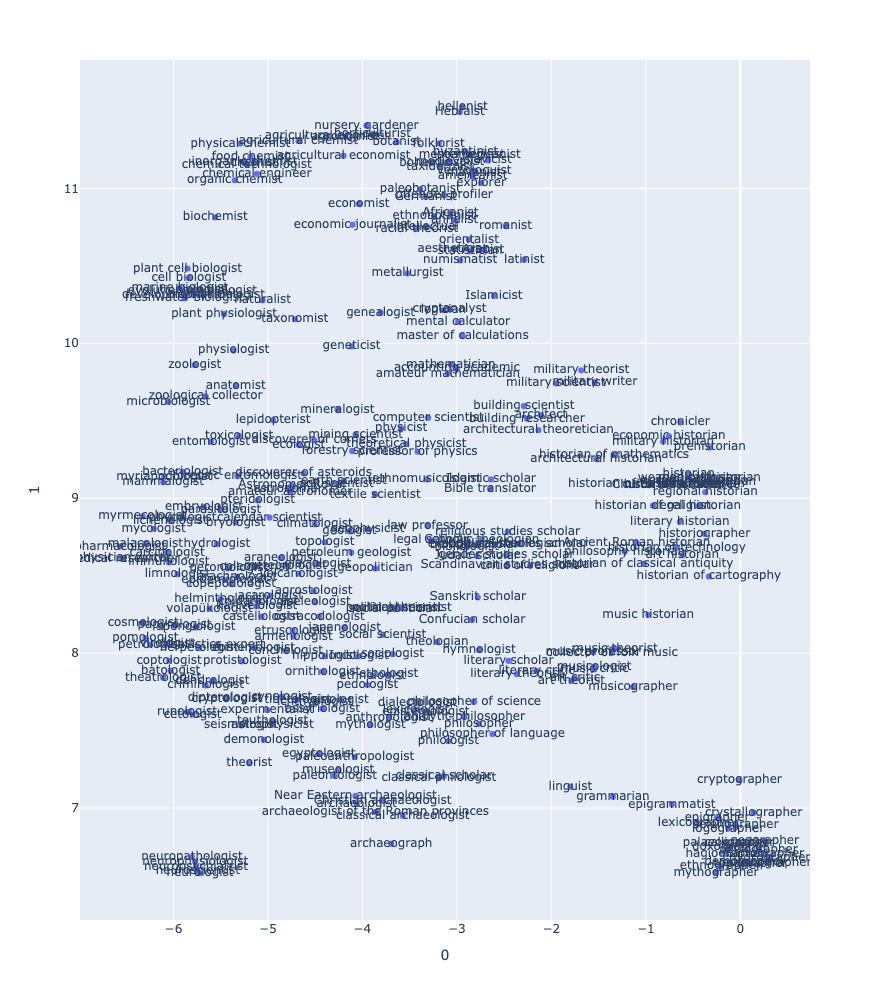

In [56]:
fig

In [66]:


df = pd.DataFrame({'occupation':list_label, 'score':[x[0] for x in order]})
df = df.sort_values('score', ascending=False).reset_index(drop=True)
df

,occupation,score
0,organic chemist,9.970654
1,physical chemist,9.947152
2,food chemist,9.861608
3,chemist,9.837849
4,inorganic chemist,9.810800
...,...,...
291,latinist,4.088506
292,americanist,4.075577
293,Africanist,4.052002
294,romanist,4.050488


In [67]:
df['order'] = df.index

In [68]:
df.to_clipboard(index=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
